# CDDP Tutorial - Cartpole

This notebook shows how to use the CDDP algorithm to solve the cartpole problem.
© Tomohiro Sasaki, 2023

In [ ]:
import Pkg 
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [1]:
using Plots; gr()
using LinearAlgebra
using BenchmarkTools
using Printf
using Revise
using CDDP

In [38]:
includet("../src/models/cartpole.jl")
model = CartPole()
x_dim, u_dim = model.x_dim, model.u_dim

tf = model.tf
tN = model.tN
dt = model.dt

x_init = model.x_init
x_final = model.x_final
;

In [115]:
function ell_cost(
    x::Vector,
    u::Vector,
    x_ref::Vector{Float64};
)
    
    Q = 1.0e-2*Diagonal(ones(x_dim))
    R = 1.0e-1*Diagonal(ones(u_dim))
    return  0.5 * transpose(x - x_ref) * Q * (x - x_ref) + 0.5 * transpose(u) * R * u
end

function phi_cost(
    x::Vector,
    x_final::Vector{Float64};
)
    Qf = 1.0e+2*Diagonal(ones(x_dim))
    return 0.5 * transpose(x - x_final) * Qf * (x - x_final)
end
;

## initial trajectory

In [116]:
using DataInterpolations

X0, U0 = initialize_trajectory(model);

# U0 = 0.02 * randn(tN, u_dim) .- 0.01
# # U0 = zeros(tN, u_dim)
# U0 = Vector[U0[t, :] for t in axes(U0,1)]
# # convert U array into U_func as a continuous function
# U0 = linear_interpolation((collect(LinRange(0.0, tf, tN)),), U0, extrapolation_bc = Line())

# X0 = simulate_trajectory(model, x_init, U0, tf, dt)

# X_ref = Vector[x_final for t in 1:tN+1]
# X_ref =  CubicSpline(X_ref, 0:dt:tf)
X_ref = simulate_trajectory(model, x_final, U0, tf, dt)
;

## iLQR solver

In [309]:
includet("../src/models/cartpole.jl")
model = CartPole()
tf = 5.
tN = 100
dt = tf/tN

x_init = [0. ; 0. ; 0. ; 0.]
prob = iLQRProblem(
    model, 
    tf, 
    tN, 
    dt, 
    x_dim, 
    u_dim, 
    ell_cost, 
    phi_cost, 
    model.f, 
    empty, 
    x_init, 
    x_final, 
    X_ref)
    
sol = solve_ilqr(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-20, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-20, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))

X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start iLQR Problem Solver 
**************************************************************************************
iter    objective 
                
0       493.726960,  
                
1       348.466173,  
                


2       273.518064,  
                
3       118.616501,  
                


4       84.953915,  
                
5       84.089218,  
                


6       54.276011,  
                
7       46.817503,  
                


8       45.523179,  
                
9       44.853664,  
                


iter    objective 
                
10       44.396278,  
                


11       43.748196,  
                
12       24.488881,  
                


13       24.342080,  
                
14       20.376578,  
                


15       18.805828,  
                
16       18.215219,  
                


17       16.781553,  
                
18       15.429819,  
                


19       14.420084,  
                
iter    objective 
                


20       13.611097,  
                
21       12.975432,  
                


22       10.082721,  
                
23       5.723352,  
                


24       4.478959,  
                
25       3.929549,  
                


26       1.731088,  
                
27       1.709023,  
                


**************************************************************************************
>>> Successfully Finished iLQR Problem Solver <<< 
**************************************************************************************


In [305]:
X_ilqr(tN*dt)

4-element Vector{Float64}:
 -0.4363433061598104
  1.9018890663141383
 -0.21708220081938648
 -5.022660874207456

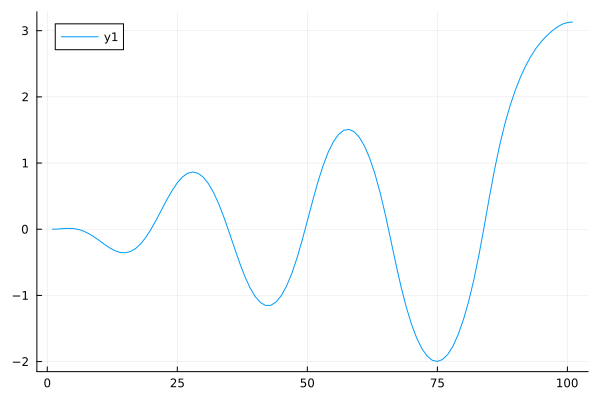

In [316]:
X_arr = Array{Float64}(undef, x_dim, tN+1)

for t in 1:tN+1
    X_arr[:,t] = X_ilqr((t-1)*dt)
end
plot(X_arr[2,:])
# plot!(X_ilqr[2,:])

In [317]:
includet("../src/models/cartpole.jl")
model = CartPole()
tf = 5.
tN = 100
dt = tf/tN

x_init = [0. ; 0. ; 0. ; 0.]
prob = DDPProblem(
    model, 
    tf, 
    tN, 
    dt, 
    x_dim, 
    u_dim, 
    ell_cost, 
    phi_cost, 
    model.f, 
    empty, 
    x_init, 
    x_final, 
    X_ref)
    
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-5, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-3, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))

X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ddp, U_ddp, J_ddp, gains_ddp = sol.X, sol.U, sol.J, sol.gains;

**************************************************************************************
>>> Start DDP Problem Solver 
**************************************************************************************
iter    objective  
                
0       493.726960,  
                
1       335.784756,  
                


2       264.562438,  
                
3       121.239800,  
                


4       87.612202,  
                
5       85.975018,  
                


6       53.892242,  
                
7       47.688072,  
                


8       45.855645,  
                
9       44.945099,  
                


iter    objective  
                
10       44.332663,  
                


11       44.146446,  
                
12       21.866756,  
                


13       19.758675,  
                
14       17.439471,  
                


15       15.342749,  
                
16       14.069913,  
                


17       13.054541,  
                
18       12.592385,  
                


19       11.598205,  
                
iter    objective  
                


20       10.910876,  
                
21       10.481375,  
                


22       3.917117,  
                
23       3.671232,  
                


24       3.667003,  
                
25       3.422130,  
                


26       2.453455,  
                
27       2.195147,  
                


28       2.187741,  
                
29       2.165314,  
                


iter    objective  
                
30       1.938374,  
                


31       1.791898,  
                
32       1.789658,  
                


33       1.719700,  
                
34       1.700528,  
                


35       1.682263,  
                
36       1.667569,  
                


37       1.603365,  
                
38       1.591884,  
                


39       1.591884,  
                
iter    objective  
                


40       1.591884,  
                
41       1.591884,  
                


42       1.591884,  
                
43       1.591884,  
                


44       1.591884,  
                
45       1.591884,  
                


46       1.591884,  
                
47       1.591884,  
                


48       1.591884,  
                
49       1.591884,  
                


iter    objective  
                
50       1.591884,  
                


51       1.591884,  
                
52       1.591884,  
                


53       1.591884,  
                
54       1.591884,  
                


55       1.591884,  
                
56       1.563373,  
                


57       1.563373,  
                
58       1.553332,  
                


59       1.553332,  
                
iter    objective  
                


60       1.551802,  
                
61       1.551802,  
                


62       1.546929,  
                
63       1.546929,  
                


64       1.542741,  
                
65       1.542741,  
                


66       1.538404,  
                
67       1.538404,  
                


68       1.534723,  
                
69       1.534723,  
                


iter    objective  
                
70       1.531211,  
                
71       1.531211,  
                
72       1.528041,  
                


73       1.528041,  
                
74       1.525128,  
                


75       1.525128,  
                
76       1.522525,  
                


77       1.522525,  
                
78       1.520210,  
                


79       1.520210,  
                
iter    objective  
                


80       1.518187,  
                
81       1.518187,  
                


82       1.516440,  
                
83       1.516440,  
                


84       1.514957,  
                
85       1.514957,  
                


86       1.513726,  
                
87       1.513726,  
                


88       1.512738,  
                
89       1.512738,  
                


iter    objective  
                
90       1.511980,  
                


91       1.511980,  
                
92       1.511440,  
                


93       1.511440,  
                
94       1.511106,  
                


95       1.511106,  
                
96       1.510965,  
                


97       1.510965,  
                
98       1.510965,  
                


99       1.508997,  
                
**************************************************************************************
>>> Successfully Finished DDP Problem Solver <<< 
**************************************************************************************


┌ Info: Saved animation to /Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif
└ @ Plots /Users/astomodynamics/.julia/packages/Plots/esM5q/src/animation.jl:156


Plots.AnimatedGif("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif")
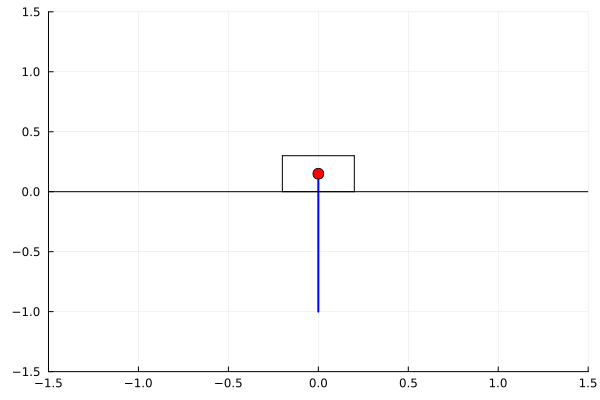

In [318]:
function make_gif(X)
    
    anime = Animation()
    for k in 0:tN
        x = X(k*dt)
        xc = x[1]
        θ = x[2]
        xx = sin(θ)
        xy = -cos(θ)
        r_cart = [xc, 0.15]
        plt = plot([r_cart[1], xx], [r_cart[2], xy], label="",xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), color=:blue, linewidth=2, equal_aspect=true)
        scatter!((r_cart[1],r_cart[2]), color=:red, markersize=6, legend=false, marker=:circle, fillcolor=nothing)
        
        # horizontal line
        plot!([-1.5, 1.5], [0., 0.], label="", color=:black, linewidth=1)
        
        # right wall
        plot!([r_cart[1]+0.2, r_cart[1]+0.2], [0., 0.3], label="", color=:black, linewidth=1)
        # left wall
        plot!([r_cart[1]-0.2, r_cart[1]-0.2], [0., 0.3], label="", color=:black, linewidth=1)
        # top wall
        plot!([r_cart[1]-0.2, r_cart[1]+0.2], [0.3, 0.3], label="", color=:black, linewidth=1)
        # bottom wall
        plot!([r_cart[1]-0.2, r_cart[1]+0.2], [0., 0.], label="", color=:black, linewidth=1)

        frame(anime, plt)
    end

    gif(anime, "../results/cartpole.gif", fps = 15)
end

make_gif(X_ddp)

In [194]:
using DataInterpolations, Plots
gr()
# Dependent variable
u = [14.7, 11.51, 10.41, 14.95, 12.24, 11.22]
# Independent variable
t = [0.0, 62.25, 109.66, 162.66, 205.8, 252.3]
A = CubicSpline(u,t)

12-element CubicSpline{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, true, Float64}:
  14.7
  11.51
  10.41
  14.95
  12.24
  11.22
   0.0
  62.25
 109.66
 162.66
 205.8
 252.3

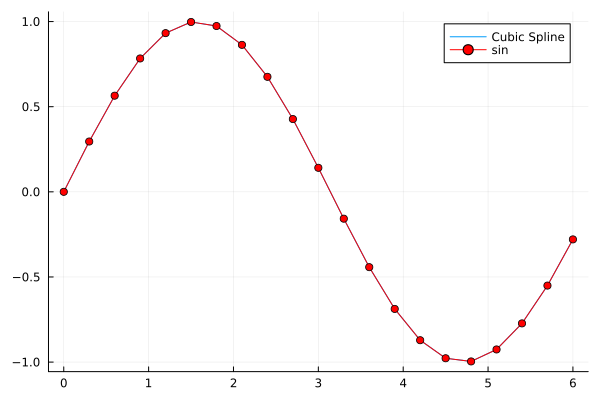

In [143]:
t = 0:0.3:2*pi
s = sin.(t)
c = cos.(t)
u = s
uu = Vector[[sin(k),cos(k)] for k in t]
# uu::Vector{Matrix{Float64}} = [[cos(k) -sin(k); sin(k) cos(k)] for k in t]
A = CubicSpline(uu,t)
A = BSplineInterpolation(u,t,4, :ArcLen,:Average)


plot(t, A.(t), label="Cubic Spline")
plot!(t, s, label="sin", linestyle=:solid, linewidth=1, color=:red, marker=:circle)

In [131]:
A_mat = zeros(2,2,length(t)+10)
for k in 1:length(t)+10
    A_mat[:,:,k] = A(k*0.01)
end

plot(A_mat[1,1,:], label="Cubic Spline")
plot!(A_mat[2,2,:], label="Cubic Spline")

ArgumentError: ArgumentError: indexed assignment with a single value to possibly many locations is not supported; perhaps use broadcasting `.=` instead?